In [ ]:
!pip install contractions

     |████████████████████████████████| 284 kB 5.4 MB/s 
     |████████████████████████████████| 321 kB 39.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85442 sha256=c1924469f6647f9b851505d679b02f8b9ac0c7fce6e21db54dc76bbabb012484
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


# Importing Libraries

In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing unclean datasets

In [ ]:
# Reading the training and validation dataset
df_train = pd.read_csv('/content/gdrive/MyDrive/datarush/train.csv')
df_valid = pd.read_csv('/content/gdrive/MyDrive/datarush/validation.csv')

## Cleaning datasets with build functions


In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def clean_abstract(text):
  text = re.sub('[^a-z\s]', ' ', text.lower())
  text = [i.lower() for i in text.split() if i not in nlp.Defaults.stop_words]
  text = [lemmatizer.lemmatize(i) for i in text]
  text = ' '.join(text)
  text.replace('\n',' ')
  return text

In [ ]:
import contractions
import unicodedata
import re

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    document = document.lower()
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions    
    document = expand_contractions(document)
               
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
        
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document

In [ ]:
df_train['abstract'] = df_train['abstract'].apply(pre_process_document)
df_valid['abstract'] = df_valid['abstract'].apply(pre_process_document)

## Saving clean preprocess data

In [ ]:
df_train.to_csv("clean_train_preprocess.csv")
df_valid.to_csv("clean_valid_preprocess.csv")

In [ ]:
!cp clean_train_preprocess.csv "/content/gdrive/MyDrive/Amalgam_clean/"
!cp clean_valid_preprocess.csv "/content/gdrive/MyDrive/Amalgam_clean/"

## Importing clean lemmatize data

In [ ]:
df_clean_train = pd.read_csv('/content/gdrive/MyDrive/Amalgam_clean/clean_train_preprocess.csv')
df_clean_valid = pd.read_csv('/content/gdrive/MyDrive/Amalgam_clean/clean_valid_preprocess.csv')

##Importing clean stemmed data

In [ ]:
df_clean_train = pd.read_csv('/content/gdrive/MyDrive/Amalgam/clean_train.csv')
df_clean_valid = pd.read_csv('/content/gdrive/MyDrive/Amalgam/clean_valid.csv')

## Checking for null

In [ ]:
#checking for null values
df_clean_train.isna().sum()

Unnamed: 0      0
id              0
abstract        1
category        0
category_num    0
dtype: int64

In [ ]:
is_NaN = df_clean_train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_clean_train[row_has_NaN]
rows_with_NaN

,Unnamed: 0,id,abstract,category,category_num
112839,112839,59911,NaN,cs-LG,40


In [ ]:
df_clean_train.dropna(inplace=True)

In [ ]:
df_clean_valid.isna().sum()

Unnamed: 0      0
id              0
abstract        0
category        0
category_num    0
dtype: int64

In [ ]:
X_train, y_train = df_clean_train['abstract'],df_clean_train['category']
X_valid, y_valid = df_clean_valid['abstract'],df_clean_valid['category']

In [ ]:
X_train[0]

'bacteria expos multipl stimuli complex environ effici chemotact decis critic surviv grow nativ environ bacteri respons environment stimuli depend ratio correspond chemoreceptor incorpor signal machineri individu cell analyz collect motion popul escherichia coli bacteria respons stimuli mainli serin methyl aspart measp dimension dimension environ inspir experiment result y kalinin et al j bacteriol suitabl condit ratio main chemoreceptor individu cell tar tsr specif threshold bacteria gradient serin ratio greater threshold group bacteria gradient measp final examin theori mont carlo agent base simul verifi result qualit agre experiment result y kalinin et al'

## Under and Over Sampling

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit(y_train)

y_train = label_encoder.transform(y_train)
y_valid = label_encoder.transform(y_valid)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from collections import Counter
def sampling_strategy(y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v > n_samples}
    elif t == 'minority':
        # Since SMOTE depends on KNN, filtering out those samples that occur less than 10 times
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v < n_samples and v > 10}
    sampling_strategy = {k:n_samples for k,v in target_classes.items()}
    return sampling_strategy

In [ ]:
over_sampler_ss = sampling_strategy(y_train,1000,t='minority')

In [ ]:
under_sampler_ss = sampling_strategy(y_train,8000,t='majority')

In [ ]:
under_sampler=RandomUnderSampler(sampling_strategy=under_sampler_ss,random_state=20)
X_under,y_under=under_sampler.fit_resample(np.array(X_train).reshape(-1,1), y_train)

In [ ]:
over_sampler=RandomOverSampler(sampling_strategy=over_sampler_ss,random_state=20)
X_over,y_over=over_sampler.fit_resample(X_under,y_under)

In [ ]:
X_over.shape

(381961, 1)

In [ ]:
from keras.utils import np_utils
y_over_enc = np_utils.to_categorical(y_over)

In [ ]:
#Total number of categories
n_classes = len(y_over_enc[0])
n_classes

156

In [ ]:
#Encoding validation dataset according to total number of categories in train dataset
y_valid_enc = np_utils.to_categorical(y_valid, num_classes=n_classes)

# Embedding layer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-01-26 03:40:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-26 03:40:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-26 03:40:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_index = {}
with open("/content/glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
train_xx = X_over
valid_xx = df_clean_valid['abstract']

In [ ]:
trainDF = pd.concat([pd.Series(train_xx.flatten()),valid_xx], ignore_index=True)

In [ ]:
trainDF = trainDF.to_frame(name='text')

In [ ]:
# create a tokenizer 
from keras.preprocessing import text, sequence
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

In [ ]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(pd.Series(train_xx.flatten())), maxlen=100)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_xx), maxlen=100)

In [ ]:
# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,1))
tfidf_vectorizer = tfidf.fit(pd.Series(X_over.flatten()))
tf_len = len(tfidf_vectorizer.vocabulary_)

X_over = tfidf_vectorizer.transform(pd.Series(X_over.flatten())).astype('float32')
X_valid = tfidf_vectorizer.transform(X_valid).astype('float32') 

# CNN

In [ ]:
from keras import layers,models

def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((100, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu", kernel_initializer= 'glorot_uniform')(embedding_layer)
    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)
    pooling_layet = layers.Dropout(0.5)(pooling_layer)
    
    # Add the output Layers
    output_layer1 = layers.Dense(512, activation="relu")(pooling_layer)
    output_layer1= layers.BatchNormalization()(output_layer1)
    output_layer1 = layers.Dropout(0.5)(output_layer1)

     # Add the output Layers
    output_layer2 = layers.Dense(256, activation="relu")(output_layer1)
    output_layer2 = layers.BatchNormalization()(output_layer2)
    output_layer2 = layers.Dropout(0.5)(output_layer2)

     # Add the output Layers
    output_layer3 = layers.Dense(128, activation="relu")(output_layer2)
    output_layer3 = layers.BatchNormalization()(output_layer3)
    output_layer3 = layers.Dropout(0.3)(output_layer3)

    output_layer3 = layers.Dense(n_classes, activation="softmax")(output_layer3)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer3)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
model = create_cnn()

In [ ]:
history = model.fit(train_seq_x, y_over_enc, epochs=10,validation_data=(valid_seq_x, y_valid_enc))

Epoch 1/10
11937/11937 [==============================] - 270s 22ms/step - loss: 3.2104 - accuracy: 0.2093 - val_loss: 2.2695 - val_accuracy: 0.3859
Epoch 2/10
11937/11937 [==============================] - 267s 22ms/step - loss: 2.7845 - accuracy: 0.2790 - val_loss: 2.1777 - val_accuracy: 0.3987
Epoch 3/10
11937/11937 [==============================] - 267s 22ms/step - loss: 2.6960 - accuracy: 0.2968 - val_loss: 2.0749 - val_accuracy: 0.4272
Epoch 4/10
11937/11937 [==============================] - 269s 23ms/step - loss: 2.6506 - accuracy: 0.3074 - val_loss: 2.0664 - val_accuracy: 0.4266
Epoch 5/10
11937/11937 [==============================] - 266s 22ms/step - loss: 2.6137 - accuracy: 0.3157 - val_loss: 2.0168 - val_accuracy: 0.4384
Epoch 6/10
11937/11937 [==============================] - 266s 22ms/step - loss: 2.5896 - accuracy: 0.3204 - val_loss: 2.0213 - val_accuracy: 0.4374
Epoch 7/10
11937/11937 [==============================] - 266s 22ms/step - loss: 2.5722 - accuracy: 0.3232

In [ ]:
model.save("/content/gdrive/MyDrive/Amalgam/cnn2.h5")

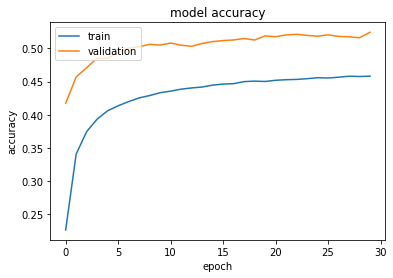

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

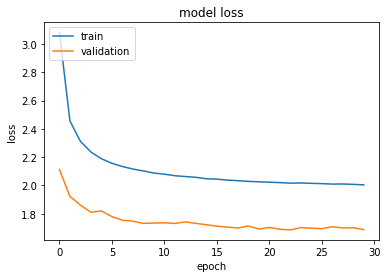

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#importing test.csv file
df_test = pd.read_csv('/content/gdrive/MyDrive/datarush/test.csv')

In [ ]:
df_test['abstract'] = df_test['abstract'].apply(pre_process_document)

In [ ]:
X_test = df_test['abstract']
X_test = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=100)

In [ ]:

test_classes = model.predict(X_test, verbose=0)

In [ ]:
test_predictions = []
for i in test_classes:
    maxx = np.argmax(i)
    test_predictions.append(maxx)
test_predictions= np.array(test_predictions)
test_predictions

array([ 25,  54,  68, ..., 125,  25,  92])

In [ ]:
predicted_classes = []
for i in test_predictions:
    predicted_classes.append(label_encoder.classes_[i])

In [ ]:
solution_df = pd.DataFrame()

In [ ]:
solution_df['id'] = df_test['id']

In [ ]:
solution_df['category_num'] = pd.Series(test_predictions)

In [ ]:
solution_df.to_csv('solution.csv', index=False)

In [ ]:
!cp solution.csv "/content/gdrive/MyDrive/Amalgam/"